In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


from nnood.paths import preprocessed_data_base
def wl_to_lh(window, level):
    low = level - window / 2
    high = level + window / 2
    return low,high

def display_image(img, phys_size=None, window=None, level=None, existing_ax=None):

    if window is None:
        window = np.max(img) - np.min(img)

    if level is None:
        level = window / 2 + np.min(img)

    low,high = wl_to_lh(window,level)

    if existing_ax is None:
        # Display the orthogonal slices
        fig, axes = plt.subplots(figsize=(14, 8))
    else:
        axes = existing_ax

    axes.imshow(img, clim=(low, high), extent= None if phys_size is None else (0, phys_size[0], phys_size[1], 0), cmap='gray')

    if existing_ax is None:
        plt.show()
        
def print_stats(arr):
        print(np.mean(arr),', ',np.std(arr))
        print(np.min(arr), '-', np.max(arr))
        print(arr.shape)

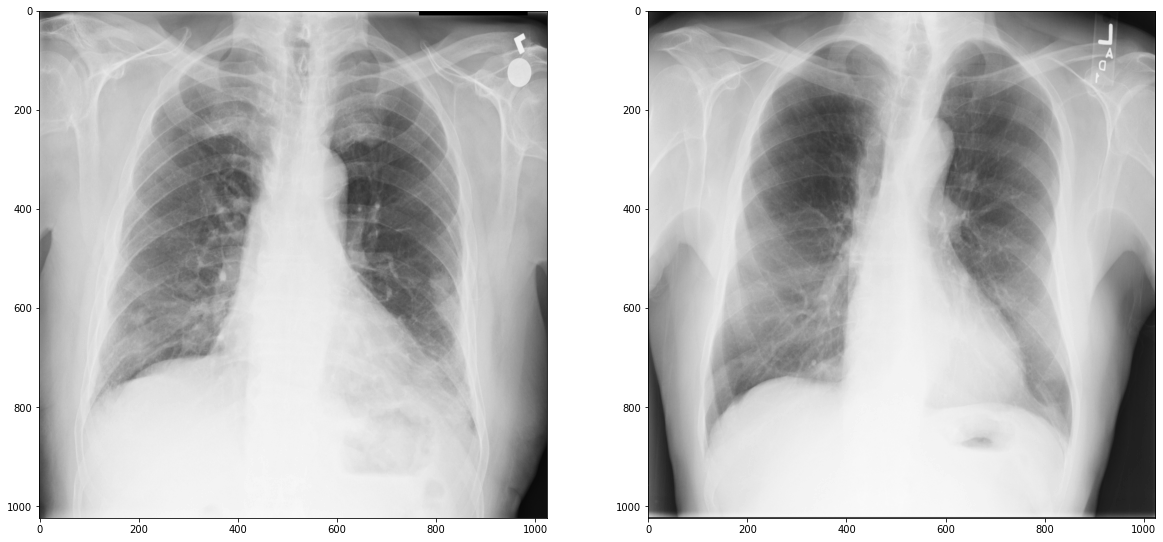

In [2]:
from nnood.paths import default_data_identifier, default_plans_identifier
from nnood.utils.file_operations import load_pickle
from nnood.training.dataloading.dataset_loading import load_dataset_filenames
from nnood.preprocessing.normalisation import denormalise

dataset_name = 'chestXray14_PA_male'

plans_file = Path(preprocessed_data_base, dataset_name, default_plans_identifier)
test_image_dir = Path(preprocessed_data_base, dataset_name, default_data_identifier + '_stage0')

plans = load_pickle(plans_file)

dataset = load_dataset_filenames(test_image_dir, plans['dataset_properties']['sample_identifiers'])

k1, k2 = list(dataset.keys())[:2]

test_image1 = np.load(dataset[k1]['data_file'])['data']
test_prop1 = load_pickle(dataset[k1]['properties_file'])
test_image2 = np.load(dataset[k2]['data_file'])['data']
test_prop2 = load_pickle(dataset[k2]['properties_file'])

norm_args = (plans['normalization_schemes'],
             plans['dataset_properties']['intensity_properties'],
             test_prop1['channel_intensity_properties'])

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

display_image(np.moveaxis(denormalise(test_image1, *norm_args), 0, -1), existing_ax=axes[0])
display_image(np.moveaxis(denormalise(test_image2, *norm_args), 0, -1), existing_ax=axes[1])

In [3]:
from nnood.self_supervised_task.fpi import FPI
from nnood.self_supervised_task.rect_fpi import RectFPI
from nnood.self_supervised_task.cutpaste import CutPaste
from nnood.self_supervised_task.opencv_pii import OpenCVPII
from nnood.self_supervised_task.opencv_nsa import OpenCVNSA, OpenCVNSAMixed
from nnood.self_supervised_task.pii import PII
from nnood.self_supervised_task.nsa import NSA, NSAMixed
from time import time

task = OpenCVNSAMixed()

start = time()
task.calibrate(dataset, plans)
print('took ', time() - start)

took  54.928744077682495


In [4]:
# import cv2
# task.blender.mode = cv2.MIXED_CLONE

Anomaly locations:  [array([427, 384]), array([290, 501]), array([322, 246])]
0.0013599711024859787 ,  0.998675494460228
-3.7597467675835037 - 1.5021848454904827
(1, 1024, 1024)
0.013612410095245024 ,  0.10805453164983381
0.0 - 1.0
(1, 1024, 1024)


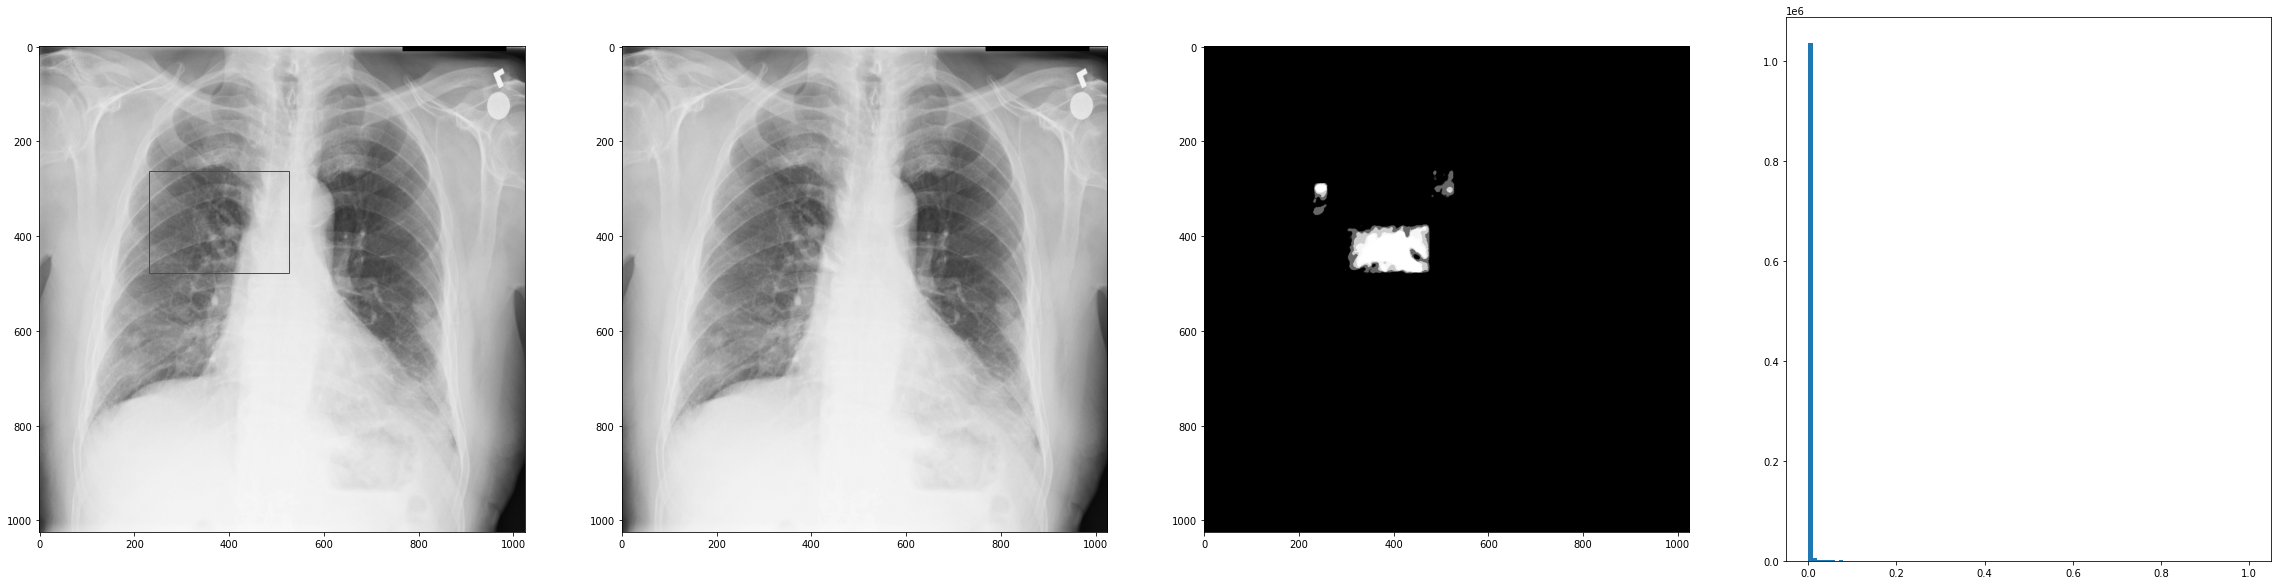

In [5]:
from matplotlib.patches import Rectangle

dest_bbox = np.array([[200, 600], [200, 600]])
task.prev_sample = test_image2.copy()

def bbox(img):
    rows = np.any(img, axis=0)
    cols = np.any(img, axis=1)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

patch_img, patch_label, anomaly_locations = task.apply(test_image1.copy(), None, test_prop1, lambda _: (test_image2.copy(), None), dest_bbox=dest_bbox, return_locations=True)

print('Anomaly locations: ', anomaly_locations)
print_stats(patch_img)
print_stats(patch_label)
anom_bbox = bbox(patch_label[0])

fig, axes = plt.subplots(ncols=4, figsize=(40, 10))

display_image(np.moveaxis(denormalise(test_image1, *norm_args), 0, -1), existing_ax=axes[0])
axes[0].add_patch(Rectangle((anom_bbox[0], anom_bbox[2]), anom_bbox[1] - anom_bbox[0], anom_bbox[3] - anom_bbox[2], fill=False, edgecolor='red'))

display_image(np.moveaxis(denormalise(patch_img, *norm_args), 0, -1), existing_ax=axes[1])
#axes[1].add_patch(Rectangle((anom_bbox[0], anom_bbox[2]), anom_bbox[1] - anom_bbox[0], anom_bbox[3] - anom_bbox[2], fill=False, edgecolor='red'))

display_image(patch_label[0], existing_ax=axes[2])
dif = np.abs(denormalise(patch_img, *norm_args) - denormalise(test_image1, *norm_args))
axes[3].hist(dif[dif != 0].flatten(), bins=100, range=(0, 1))

plt.show()

In [ ]:
from tqdm import tqdm
from skimage import measure

all_dataset_names = ['chestXray14_PA_male', 'chestXray14_PA_female']

tasks = [FPI, PII, CutPaste, NSA, NSAMixed]

cutpaste_transforms = None

calibrated_tasks = {}

for dset in all_dataset_names:
    t_objects = [t() for t in tasks]

    plans_file = Path(preprocessed_data_base, dset, default_plans_identifier)
    test_image_dir = Path(preprocessed_data_base, dset, default_data_identifier + '_stage0')

    plans = load_pickle(plans_file)

    dataset = load_dataset_filenames(test_image_dir, plans['dataset_properties']['sample_identifiers'])
    
    for t in tqdm(t_objects):
        if t.__class__.__name__ == 'CutPaste':
            if cutpaste_transforms is None:
                t.calibrate(dataset, plans)
                cutpaste_transforms = t.transformations
            else:
                # Cheat calibration, as only looks for highest value.
                t.transformations = cutpaste_transforms
                t.calibrated = True
        else:
            t.calibrate(dataset, plans)
    
    calibrated_tasks[dset] = t_objects

In [ ]:

    
ax_row_params = {'fontsize': 30, 'fontname': 'Times New Roman', 'labelpad': 15}
ax_title_params = {'fontsize': 30, 'fontname': 'Times New Roman', 'pad': 15}

for dset in all_dataset_names:

    plans_file = Path(preprocessed_data_base, dset, default_plans_identifier)
    test_image_dir = Path(preprocessed_data_base, dset, default_data_identifier + '_stage0')

    plans = load_pickle(plans_file)

    dataset = load_dataset_filenames(test_image_dir, plans['dataset_properties']['sample_identifiers'])

    dataset_keys = list(dataset.keys())[:len(tasks) + 1]
    dataset_samples = [np.load(dataset[k]['data_file'])['data'] for k in dataset_keys]
    dataset_props = [load_pickle(dataset[k]['properties_file']) for k in dataset_keys]
    
    fig, ax = plt.subplots(ncols=3, nrows=len(tasks), sharex=True, sharey=True, figsize=(4*3, 4*len(tasks)))
    
    # Add images
    for i, t in enumerate(t_objects):
        
        orig_img = dataset_samples[i]
        orig_img_props = dataset_props[i]
        orig_norm_args = (plans['normalization_schemes'],
                          plans['dataset_properties']['intensity_properties'],
                          orig_img_props['channel_intensity_properties'])
        
        next_img = dataset_samples[i + 1]
    
        patch_img, patch_label = t.apply(orig_img.copy(), None, orig_img_props, lambda _: (next_img.copy(), None))
        
        anomaly_contours = measure.find_contours(patch_label[0] > 0)
        
        contour_bboxes = [(np.min(ac[:, 0]), np.max(ac[:, 0]), np.min(ac[:, 1]), np.max(ac[:, 1])) for ac in anomaly_contours]
        
        outer_contours = []
        
        def bbox_contains(outer, inner):
            
            return outer[0] <= inner[0] and inner[1] <= outer[1] and outer[2] <= inner[2] and inner[3] <= outer[3] 
            
        for ac, ac_bbox in zip(anomaly_contours, contour_bboxes):
            
            within_current = [bbox_contains(bb, ac_bbox) for _, bb in outer_contours]
            
            if any(within_current):
                continue
                
            outer_contours = [(ac_old, bb) for ac_old, bb in outer_contours if not bbox_contains(ac_bbox, bb)] + [(ac, ac_bbox)]
        
        final_contours = [ac for ac, _ in outer_contours]
        
        display_image(np.moveaxis(denormalise(orig_img, *orig_norm_args), 0, -1), existing_ax=ax[i][0])
        display_image(np.moveaxis(denormalise(patch_img, *orig_norm_args), 0, -1), existing_ax=ax[i][1])
        ims = ax[i][2].imshow(patch_label[0], vmin=0, vmax=1, cmap='gray')
        fig.colorbar(ims, ax=ax[i][2])
        
        for a_c in final_contours:
            # USE DOTTED LINES
            ax[i,0].plot(a_c[:, 1], a_c[:, 0], linewidth=1, color='red', linestyle='--', dashes=(4, 6))
            ax[i,1].plot(a_c[:, 1], a_c[:, 0], linewidth=1, color='red', linestyle='--', dashes=(4, 6))
                
    # Add titles
    ax[0][0].set_title('Original', **ax_title_params)
    ax[0][1].set_title('Synthetic Outlier', **ax_title_params)
    ax[0][2].set_title('Label', **ax_title_params)
    
    for i, t in enumerate(tasks):
        ax[i][0].set_ylabel(t.__name__, **ax_row_params)
    
    for axi in ax.ravel():
        axi.set_xticks([])
        axi.set_yticks([])

    fig.tight_layout()
    
    fig.savefig(dset + '_syn_examples.pdf')
    fig.show()
